###Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
zf = ZipFile('/content/drive/Shareddrives/Aviral (B.Tech Internship)/nucleisegmentationbenchmark.zip', 'r')
zf.extractall('/content')
zf.close()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch.autograd import Variable
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch
import functools
%pylab inline
import argparse
import os
import glob
import random
import numpy as np
import math
import itertools
import time
import datetime
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


###Parser

In [ ]:
Parser = argparse.ArgumentParser()

Parser.add_argument('--img_height', type=int, default=512, help='size of image height')
Parser.add_argument('--img_width', type=int, default=512, help='size of image width')
Parser.add_argument('--channels', type=int, default=3, help='number of image channels')
Parser.add_argument('--sample_interval', type=int, default=30, help='interval between sampling of images from generators')
Parser.add_argument('--checkpoint_interval', type=int, default=20, help='interval between model checkpoints')
Parser.add_argument('--path', type=str, default="/content/Dataset", help='path to code and data')
Parser.add_argument('--epoch', type=int, default=0, help='epoch to start training from')
Parser.add_argument('--n_epochs', type=int, default=50, help='number of epochs of training')
Parser.add_argument('--dataset_name', type=str, default="dataset_hist", help='name of the dataset')
Parser.add_argument('--batch_size', type=int, default=5, help='size of the batches')
Parser.add_argument('--lr', type=float, default=0.00008, help='adam: learning rate')
Parser.add_argument('--b1', type=float, default=0.5, help='adam: decay of first order momentum of gradient')
Parser.add_argument('--b2', type=float, default=0.999, help='adam: decay of first order momentum of gradient')
Parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
Parser.add_argument('--decay_epoch', type=int, default=40, help='epoch from which to start lr decay')

args, _ = Parser.parse_known_args()
opt = Parser.parse_args(args=[])
print(opt)

Namespace(b1=0.5, b2=0.999, batch_size=5, channels=3, checkpoint_interval=20, dataset_name='dataset_hist', decay_epoch=40, epoch=0, img_height=512, img_width=512, lr=8e-05, n_cpu=8, n_epochs=50, path='/content/Dataset', sample_interval=30)


### Define Models

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
#----------------------------------------
#      U-Net ++ model for Generator
#----------------------------------------

class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class GeneratorUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])   #3,32,32
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])     #32,64,64
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])     #64,128,128
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])     #128,256,256
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])     #256,512,512

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])    #96,32,32
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])    #192,64,64
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])    #384,128,128
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])    #768,256,256

        #self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])  #
        self.conv0_2 = VGGBlock(nb_filter[0], nb_filter[0], nb_filter[0])  #
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        #self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])

        #self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv0_3 = VGGBlock(nb_filter[0], nb_filter[0], nb_filter[0])
        #self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])
        

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)    #32,512,512
        x1_0 = self.conv1_0(self.pool(x0_0))   #64,256,256 
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))    #32,512,512
        

        x2_0 = self.conv2_0(self.pool(x1_0))    #128,128,128
        #x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))    #64,256,256
        #x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))    #
        x0_2 = self.conv0_2(x0_1)

        x3_0 = self.conv3_0(self.pool(x2_0))
        #x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        #x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(x0_2) #
        
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        #x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        #x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        
        
        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output
        

In [ ]:


##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                    nn.InstanceNorm2d(out_size),
                    nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.0)
        self.down5 = UNetDown(512, 512, dropout=0.0)
        self.down6 = UNetDown(512, 512, dropout=0.0)
        self.down7 = UNetDown(512, 512, dropout=0.0)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.0)
        self.up1 = UNetUp(512, 512, dropout=0.0)
        self.up2 = UNetUp(1024, 512, dropout=0.0)
        self.up3 = UNetUp(1024, 512, dropout=0.0)
        self.up4 = UNetUp(1024, 512, dropout=0.0)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


In [ ]:
##############################
#        Discriminator
##############################

class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc=4, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(PixelDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=2, padding=1, bias=False)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.net(img_input)

In [ ]:
from torchsummary import summary
summary(generator, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,072
              ReLU-2         [-1, 64, 256, 256]               0
          UNetDown-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]         131,072
    InstanceNorm2d-5        [-1, 128, 128, 128]               0
              ReLU-6        [-1, 128, 128, 128]               0
          UNetDown-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         524,288
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
         UNetDown-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 512, 32, 32]       2,097,152
   InstanceNorm2d-13          [-1, 512, 32, 32]               0
             ReLU-14          [-1, 512,

###Compile Model and define Loss functions

In [ ]:
## Check for GPU 
cuda = True if torch.cuda.is_available() else False

## Create Tensor type
if cuda:
  Tensor = torch.cuda.FloatTensor
else:
  Tensor = torch.FloatTensor

## Define Loss function
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

## Initialize discriminator and generator models
generator = GeneratorUNet()
discriminator = PixelDiscriminator()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()
    discriminator = torch.nn.DataParallel(discriminator).cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

## Optimisers
opti_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
opti_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

###Load Data

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)
        
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        width, height = img.size
        img_A = img.crop((0, 0, width/2, height))
        img_A = img_A.resize((512,512))

        img_B = img.crop((width/2, 0, width, height))
        img_B = img_B.convert('L')
        img_B = img_B.resize((512,512))
        img_B = np.expand_dims(img_B, axis=-1)
        #
        seed = np.random.randint(2147483647)  # make a seed with numpy generator
        random.seed(seed)  # apply this seed to img tranfsorms
        
        img_A = self.transform(img_A)
        random.seed(seed)  # apply this seed to target tranfsorms
        img_B = self.transform(img_B)
        return {'A': img_A, 'B': img_B}
        """
        img_A = transforms_RGB(img_A)
        random.seed(seed)  # apply this seed to target tranfsorms
        img_B = transforms_GRAY(img_B)
        return {'A': img_A, 'B': img_B}
        """

    def __len__(self):
        return len(self.files)

###Create Dataloader

In [ ]:
# Calculate output of image discriminator (PatchGAN)
patch = (1, opt.img_height//2**5, opt.img_width//2**5)

# Configure dataloaders and Data Augmentation
train_transforms_ = [transforms.ToTensor(),
                     transforms.RandomVerticalFlip(p=0.5),
                     transforms.RandomHorizontalFlip(p=0.5),
                     transforms.ColorJitter(hue=0.1),
                     transforms.functional.rotate()]


val_transforms_ = [transforms.ToTensor()]

dataloader = DataLoader(ImageDataset("/content/nucleisegmentationbenchmark/Train Images", transforms_=train_transforms_), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)
print('Length of training batch is: ', len(dataloader))

val_dataloader = DataLoader(ImageDataset("/content/nucleisegmentationbenchmark/Test Images", transforms_=val_transforms_), batch_size=1, shuffle=True, num_workers=1)
print('Length of validation batch is: ', len(val_dataloader))


Length of training batch is:  20
Length of validation batch is:  24


In [ ]:
"""
transforms_RGB = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
transforms_GRAY = transforms.Compose(
    [transforms.ToTensor()
    ])

dataloader = DataLoader(ImageDataset("/content/nucleisegmentationbenchmark/Train Images", transforms_=transforms_RGB), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)
print('Length of training batch is: ', len(dataloader))

val_dataloader = DataLoader(ImageDataset("/content/nucleisegmentationbenchmark/Test Images", transforms_=transforms_RGB), batch_size=1, shuffle=True, num_workers=1)
print('Length of validation batch is: ', len(val_dataloader))
"""

'\ntransforms_RGB = transforms.Compose(\n    [transforms.ToTensor(),\n    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))\n    ])\ntransforms_GRAY = transforms.Compose(\n    [transforms.ToTensor()\n    ])\n\ndataloader = DataLoader(ImageDataset("/content/nucleisegmentationbenchmark/Train Images", transforms_=transforms_RGB), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)\nprint(\'Length of training batch is: \', len(dataloader))\n\nval_dataloader = DataLoader(ImageDataset("/content/nucleisegmentationbenchmark/Test Images", transforms_=transforms_RGB), batch_size=1, shuffle=True, num_workers=1)\nprint(\'Length of validation batch is: \', len(val_dataloader))\n'

###Plots a generated sample from the validation set

In [ ]:
def sample_images(batches_done, path):
    #Plots histopathology image, ground truth, and generator prediction, from the validation set.
    images = next(iter(val_dataloader))
    real_A = Variable(images['A'].type(Tensor))
    real_B = Variable(images['B'].type(Tensor))
    real_A = transforms.Normalize((0.5), (0.5))(real_A)
    fake_B = generator(real_A)
    
    img = real_A
    imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
    plt.show()
    img = real_B
    imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic",cmap='gray')
    plt.show()
    img = fake_B
    imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic",cmap='gray')
    plt.show()

###Training with new data

In [ ]:
G_losses = []
D_losses = []
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):

        # ----------------------------
        # Model inputs, A = original histopathology image, B = ground truth binary mask
        # ----------------------------
        
        real_B = Variable(batch['B'].type(Tensor))
        real_A = Variable(batch['A'].type(Tensor))
        real_A = transforms.Normalize((0.5), (0.5))(real_A)
        ## Normalise 
        real_B = (real_B+1.0)/2.0
        

        ## Adversarial ground truth, blank tensors
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ---------------------
        #  TRAIN GENERATOR
        # ---------------------

        opti_G.zero_grad()
        
        fake_B = generator(real_A)
        fake_B = (fake_B+1.0)/2.0
        # Loss weight of L1 pixel-wise loss between translated image and real image (lambda)
        lambda_ = 0.99

        # Total G loss
        loss_G = (1-lambda_)*criterion_GAN(discriminator(real_A,fake_B), valid) + lambda_*criterion_pixelwise(fake_B, real_B)
        
        loss_GAN = criterion_GAN(discriminator(real_A,fake_B), valid)
        
        loss_G.backward()

        opti_G.step()



        # ------------------------
        #  TRAIN DISCRIMINATOR
        # ------------------------

        opti_D.zero_grad()

        # Total loss = 0.5(fake_loss+real_loss)
        loss_D = 0.5 * (criterion_GAN(discriminator(real_A,real_B), valid) + criterion_GAN(discriminator(real_A, fake_B.detach()), fake))

        loss_D.backward()
        opti_D.step()


        #-----------------
        #  Log Progress
        #-----------------

        batches_done = i+ len(dataloader)*epoch 
        

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        #--------------------------
        # Print training progress
        #--------------------------
        
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f] " %
                                                        (epoch, opt.n_epochs,
                                                        i, len(dataloader),
                                                        loss_D.item(), loss_G.item(),
                                                        loss_GAN.item()))
        # ---------------------------------
        # Plot image at sample interval from validation set
        # ---------------------------------
        if batches_done % opt.sample_interval == 0:
            sample_images(batches_done, opt.path)

    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # -----------------------
        # Save model progress
        # -----------------------
        torch.save(generator.state_dict(), '/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/generator_29_JAN_2nd3rd Layer_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), '/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/discriminator_29_JAN_2nd3rd Layer_%d.pth' % (epoch))


Output hidden; open in https://colab.research.google.com to view.

###See Results  

In [ ]:
generator.load_state_dict(torch.load('/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/U-net/generator_11_Jan_new_140.pth'))
discriminator.load_state_dict(torch.load('/content/drive/Shareddrives/Aviral (B.Tech Internship)/Saved Training Progress/U-net/discriminator_11_Jan_new_140.pth'))

<All keys matched successfully>

In [ ]:
from torchsummary import summary
summary(generator, (3, 512, 512))

In [ ]:
!nvidia-smi

Fri Jan 29 20:35:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W /  70W |   2105MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

See images from test set

In [ ]:
for i in range(30):
  imgs = next(iter(val_dataloader))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = generator(real_A)
  img = real_A
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
  plt.show()
  img = real_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()
  img = fake_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

See images from training set

In [ ]:
for i in range(96):
  imgs = next(iter(dataloader))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = generator(real_A)
  img = real_A
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
  plt.show()
  img = real_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()
  img = fake_B
  imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

###Save Generated Images

In [ ]:
for i in range(96):
  imgs = next(iter(val_dataloader))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = generator(real_A)

  img = fake_B
  imgplot = plt.imsave("/content/new_generated_masks/test_new_UNet++_generated_"+str(i)+".jpg",transforms.ToPILImage()(img[0]), cmap='gray')
  plt.show()

import shutil
shutil.move("/content/new_generated_masks","/content/drive/Shareddrives/Aviral (B.Tech Internship)/new generated masks/")

In [ ]:
for i in range(len(val_dataloader)):
  imgs = next(iter(val_dataloader))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  real_A = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))(real_A[0])
  real_A = real_A.unsqueeze(0)
  fake_B = generator(real_A)
  
  GT_img = real_B
  GT_img = transforms.ToPILImage()(GT_img[0])

  img = fake_B
  img = transforms.ToPILImage()(img[0])

  images = [GT_img, img]
  widths, heights = [512,512]

  total_width = 1024
  max_height = 512

  new_im = Image.new('L', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += 512

  new_im.save('/content/drive/Shareddrives/Aviral (B.Tech Internship)/U-Net results/'+'U-Net_test_Merged_'+str(i)+'.jpg')

###Performance Metrics

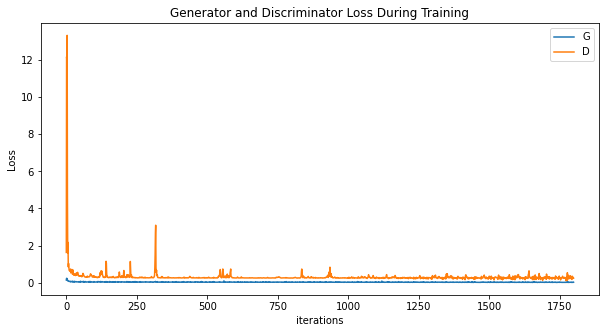

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Final Codes

In [ ]:
### Dice Loss (input : torch tensor)
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    x = 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))
    return x
### IOU (input : torch tensor)
EPS = 1e-6
def jaccard_loss(outputs, labels):
    outputs = outputs.int()
    labels = labels.int()
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + EPS) / (union + EPS)  # We smooth our devision to avoid 0/0
    return iou.mean()

from sklearn.utils.extmath import cartesian
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors.kde import KernelDensity
import skimage.io

### Haussdorf Distance (input : torch tensor)
def haussdorf_distance(set1, set2, max_ahd=np.inf):
    if len(set1) == 0 or len(set2) == 0:
        return max_ahd

    set1 = torch.squeeze(set1)
    set2 = torch.squeeze(set2)

    set1 = torch.Tensor.cpu(set1).detach().numpy()[:, :]
    set2 = torch.Tensor.cpu(set2).detach().numpy()[:, :]

    set1 = np.array(set1)
    set2 = np.array(set2)

    assert set1.ndim == 2, 'got %s' % set1.ndim
    assert set2.ndim == 2, 'got %s' % set2.ndim

    assert set1.shape[1] == set2.shape[1], \
        'The points in both sets must have the same number of dimensions, got %s and %s.'\
        % (set2.shape[1], set2.shape[1])

    d2_matrix = pairwise_distances(set1, set2, metric='euclidean')

    res = np.average(np.min(d2_matrix, axis=0)) + \
        np.average(np.min(d2_matrix, axis=1))

    return res

### Surface Distances (input : numpy arrays)    

from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
from scipy.ndimage.measurements import label, find_objects
from scipy.stats import pearsonr

def asd(result, reference, voxelspacing=None, connectivity=1):
    
    sds = __surface_distances(result, reference, voxelspacing, connectivity)
    asd = sds.mean()
    return asd


def assd(result, reference, voxelspacing=None, connectivity=1):
    """
    Average symmetric surface distance.
    """
    

    assd = numpy.mean( (asd(result, reference, voxelspacing, connectivity), asd(reference, result, voxelspacing, connectivity)) )
    return assd

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):


    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

In [ ]:
eval_dataloader_train = DataLoader(ImageDataset("/content/drive/Shareddrives/Aviral (B.Tech Internship)/U-Net results/Train", transforms_=train_transforms_), batch_size=1, shuffle=True, num_workers=opt.n_cpu)

In [ ]:
iou_list = []
dice_list = []
hausdorff_list = []
assd_list = []
asd_list = []

for i in range(len(eval_dataloader_train)):
  imgs = next(iter(eval_dataloader_train))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = real_A
  
  #print(real_A.shape)
  #print(real_B.shape)
  #print(fake_B.shape)

  real_B = (real_B+1.0)/2.0
  fake_B = (fake_B+1.0)/2.0
  real_B = transforms.Normalize((0.5),(0.5))(real_B)
  fake_B = transforms.Normalize((0.5),(0.5))(fake_B)
  

  num = jaccard_loss(fake_B, real_B)
  iou_list.append(num)
  
  num = dice_loss(fake_B, real_B)
  dice_list.append(num)

  num = haussdorf_distance(fake_B, real_B)
  hausdorff_list.append(num)

  real_B = torch.squeeze(real_B)
  fake_B = torch.squeeze(fake_B)

  real_B = torch.Tensor.cpu(real_B).detach().numpy()[:, :]
  fake_B = torch.Tensor.cpu(fake_B).detach().numpy()[:, :]

  num = asd(fake_B, real_B)
  asd_list.append(num)

  num = assd(fake_B, real_B)
  assd_list.append(num)
  
  real_A = None
  real_B = None
  fake_B = None
  torch.cuda.empty_cache()

##----------------------------------------------------------------------------------------------------------------------------------------------
print('\n\n\n-------------------------------------------')
print('-----Performance Metrics on Train set------\n')
print('IOU = '                                  +str(torch.mean(torch.stack(iou_list))))
print('Dice = '                                 +str(torch.mean(torch.stack(dice_list))))
print('Haussdorf = '                            +str(np.mean(hausdorff_list)))
print('Average Surface Symmetric Distance = '   +str(np.mean(assd_list)))
print('Average Surface Distance = '             +str(np.mean(asd_list)))




-------------------------------------------
-----Performance Metrics on Train set------

IOU = tensor(0.1864, device='cuda:0')
Dice = tensor(0.6551, device='cuda:0')
Haussdorf = 7.824056
Average Surface Symmetric Distance = 1.7415308770258016
Average Surface Distance = 0.5218544098588527


In [ ]:
eval_dataloader_test = DataLoader(ImageDataset("/content/drive/Shareddrives/Aviral (B.Tech Internship)/U-Net results/Test", transforms_=train_transforms_), batch_size=1, shuffle=True, num_workers=opt.n_cpu)

In [ ]:
iou_list_test = []
dice_list_test = []
hausdorff_list_test = []
surfd_list_test = []
assd_list_test = []
asd_list_test = []

for i in range(24):
  imgs = next(iter(eval_dataloader_test))
  real_A = Variable(imgs['A'].type(Tensor))
  real_B = Variable(imgs['B'].type(Tensor))
  fake_B = real_A

  real_B = (real_B+1.0)/2.0
  fake_B = (fake_B+1.0)/2.0
  real_B = transforms.Normalize((0.5),(0.5))(real_B)
  fake_B = transforms.Normalize((0.5),(0.5))(fake_B)
  
  num = jaccard_loss(fake_B, real_B)
  iou_list_test.append(num)
  
  num = dice_loss(fake_B, real_B)
  dice_list_test.append(num)

  num = haussdorf_distance(fake_B, real_B)
  hausdorff_list_test.append(num)

  real_B = torch.squeeze(real_B)
  fake_B = torch.squeeze(fake_B)

  real_B = torch.Tensor.cpu(real_B).detach().numpy()[:, :]
  fake_B = torch.Tensor.cpu(fake_B).detach().numpy()[:, :]

  num = asd(fake_B, real_B)
  asd_list_test.append(num)
  
  num = assd(fake_B, real_B)
  assd_list_test.append(num)
  
  real_A = None
  real_B = None
  fake_B = None
  torch.cuda.empty_cache()

##---------------------------------------------------------------------

print('\n\n\n-------------------------------------------')
print('-----Performance Metrics on Test set-----\n')
print('IOU = '                                  +str(torch.mean(torch.stack(iou_list_test))))
print('Dice = '                                 +str(torch.mean(torch.stack(dice_list_test))))
print('Haussdorf = '                            +str(np.mean(hausdorff_list_test)))
print('Average Surface Symmetric Distance = '   +str(np.mean(assd_list_test)))
print('Average Surface Distance = '             +str(np.mean(asd_list_test)))




-------------------------------------------
-----Performance Metrics on Test set-----

IOU = tensor(0.0737, device='cuda:0')
Dice = tensor(0.7812, device='cuda:0')
Haussdorf = 8.550956
Average Surface Symmetric Distance = 4.757861492989718
Average Surface Distance = 0.841579037983217


In [ ]:
torch.cuda.empty_cache()

###Playground

In [ ]:
class try_ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms_
        
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        width, height = img.size
        img_A = img.crop((0, 0, width/2, height))
        img_A = img_A.resize((512,512))

        img_B = img.crop((width/2, 0, width, height))
        img_B = img_B.convert('L')
        img_B = img_B.resize((512,512))
        img_B = np.expand_dims(img_B, axis=-1)
        #
        seed = np.random.randint(2147483647)  # make a seed with numpy generator
        random.seed(seed)  # apply this seed to img transfsorms
        img_A = try_transforms_1(img_A)
        random.seed(seed)  # apply this seed to target transfsorms
        img_B = try_transforms_2(img_B)
        return {'A': img_A, 'B': img_B}

    def __len__(self):
        return len(self.files)

In [ ]:
try_transforms_1 = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
try_transforms_2 = transforms.Compose([transforms.ToTensor()])
                #transforms.Normalize((0.5), (0.5))]
try_transforms_ = [try_transforms_1, try_transforms_2]
try_dataloader = DataLoader(try_ImageDataset("/content/nucleisegmentationbenchmark/Train Images", transforms_=None), batch_size=1, shuffle=True, num_workers=opt.n_cpu)
print('Length of training batch is: ', len(dataloader))

Length of training batch is:  20


In [ ]:
imgs = next(iter(val_dataloader))
real_A = Variable(imgs['A'].type(Tensor))
real_B = Variable(imgs['B'].type(Tensor))
fake_B = generator(real_A)
real_A = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))(real_A[0])
real_A = real_A.unsqueeze(0)
print(real_A.shape)
real_B = (real_B+1.0)/2.0
fake_B = (fake_B+1.0)/2.0

"""
img = real_A
imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic")
plt.show()
img = real_B
imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
plt.show()
img = fake_B
imgplot = plt.imshow(transforms.ToPILImage()(img[0]), interpolation="bicubic", cmap='gray')
plt.show()

print('IOU = ' + str(jc(fake_B, real_B)) )
print('Dice = '+ str(dc(fake_B, real_B)) )
print('hd  = = = '+str(hd1111(fake_B, real_B)))

real_B = torch.squeeze(real_B)
fake_B = torch.squeeze(fake_B)

real_B = torch.Tensor.cpu(real_B).detach().numpy()[:, :]
fake_B = torch.Tensor.cpu(fake_B).detach().numpy()[:, :]


print('hausdorff = '+str(hd(fake_B,real_B)))
print('IOU ===== ' + str(iou(fake_B, real_B)) )
print('Dice ===== ' + str(dice(fake_B, real_B)) )
"""

In [ ]:
real_A = None
real_B = None
fake_B = None

In [ ]:
!nvidia-smi

Fri Jan 29 21:02:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1191MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------